<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/mask_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model training on Mask 2017 dataset

The following models will be evaluated:

| Model | Backbone | Image Size | Parameters | GFLOPS 
| --- | --- | --- | --- | --- |
| SSD300 | VGG16 | 300x300 | 35.6M | 69.8 |
| SSDlite320 | MobileNetV3-Large | 320x320 | 3.4M | 1.2 |
| Faster R-CNN |  ResNet-50 FPN || 41.8M |  |
| Faster R-CNN |  MobileNetV3-Large FPN || 19.4M |  |
| Mask R-CNN |  ResNet-50 FPN || 44.4M | |
| YOLOv5s |  Custom | 640x640 | 7.3M | 17 |
| YOLOv5m |  Custom | 640x640 | 21.4M | 51.3 |
| YOLOv5l |  Custom |640x640 | 47M | 115.5 |
| YOLOv3 |  Darknet53 | 640x640 | 70M | 156.3 |
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 |
| YOLOv3-spp |  Darknet53 | 640x640 | 63M | 157.1 |

<br>

*Note: GPU Runtime needed (ex. Tesla K80, 460.32.03, 11441 MiB)*




In [ ]:
# Show system specs
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


### Get requirements

In [ ]:
%%shell

# Install Yolov5
cd /content
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install --quiet -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 9118, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 9118 (delta 79), reused 93 (delta 42), pack-reused 8965
Receiving objects: 100% (9118/9118), 9.51 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (6325/6325), done.
     |████████████████████████████████| 636 kB 6.5 MB/s 


In [ ]:
%%shell

# Install Yolov3
cd /content
git clone https://github.com/ultralytics/yolov3
cd yolov3
pip install --quiet -r requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 9862, done.
remote: Total 9862 (delta 0), reused 0 (delta 0), pack-reused 9862
Receiving objects: 100% (9862/9862), 9.19 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (6667/6667), done.


In [ ]:
%%shell

# Install flops-counter
pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.6-py3-none-any.whl size=8903 sha256=c588668d2d10abb9135df5fa089ee7f085051eae196e6622f4a423167a6cb358
  Stored in directory: /root/.cache/pip/wheels/eb/7c/e5/2332373fcac1b39ba9eb95698ac370da3e14eaba5516e22721
Successfully built ptflops


In [ ]:
%%shell

# Clone asset files
cd /content
git clone https://github.com/joangog/object-detection-assets
cd object-detection-assets
mv scripts ../
rm -rf /content/object-detection-assets/

Cloning into 'object-detection-assets'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 26 (delta 6), reused 21 (delta 4), pack-reused 0
Unpacking objects: 100% (26/26), done.


### Import packages

In [ ]:
# Import packages

from google.colab import files
from google.colab import drive

import os, sys
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import math
import time
import copy

import numpy as np
import pandas as pd
import json
import PIL

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

from ptflops import get_model_complexity_info

import scripts.utils as SU
import scripts.transforms as ST
import scripts.coco_utils as SCU
from scripts.coco_eval import CocoEvaluator

### Define auxiliary functions

In [ ]:
def convert_to_xyxy(bboxes):  # formats bboxes from (x,y,w,h) to (x,y,x,y)
  for bbox in bboxes:
    bbox[2] = bbox[0] + bbox[2]
    bbox[3] = bbox[1] + bbox[3]
  return bboxes

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, ckpt_path = None):
    model.train()
    metric_logger = SU.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SU.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = SU.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
       
        images = list(image.to(device) for image in images)
        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLOv5 package
          images = [F.to_pil_image(image) for image in images]  # Convert images from tensor to PIL

        # Format targets for torchvision models
        formatted_targets = []
        for img_targets in targets:
          # Stack boxes and labels of image targets into tensor
          boxes = torch.stack([torch.squeeze(torch.Tensor(convert_to_xyxy([target['bbox']])),0) for target in img_targets]).long()
          labels = torch.Tensor([target['category_id'] for target in img_targets]).long()
          formatted_targets.append({'boxes': boxes, 'labels': labels})
        targets = formatted_targets
              
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced = SU.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    # Save model checkpoint
    if ckpt_path is not None:
      torch.save(model.state_dict(), ckpt_path)

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, M.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, M.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = SU.MetricLogger(delimiter="  ")
    header = 'Test:'
    coco = SCU.get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    # Get label names
    label_ids = data_loader.dataset.coco.getCatIds()
    label_info = data_loader.dataset.coco.loadCats(label_ids)
    label_names = [label['name'] for label in label_info]
    labels = dict(zip(label_ids, label_names))  # Label dictionary with id-name as key-value
    labels_inv = dict(zip(label_names, label_ids))  # Inverse label dictionary with name-id as key-value

    for images, targets in metric_logger.log_every(data_loader, 100, header):

        images = list(img.to(device) for img in images)
        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLOv5 package
            images = [F.to_pil_image(image) for image in images]  # Convert images from tensor to PIL

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        model_time = time.time()
        outputs = model(images)  # Get model predictions
        model_time = time.time() - model_time

        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLO package
            # Format outputs to COCO format
            outputs_formatted = []
            for img_outputs in outputs.xyxy:
                output_bboxes = img_outputs[:, :4]
                output_scores = img_outputs[:, 4]
                output_labels = img_outputs[:, 5].to(cpu_device).apply_(
                    lambda x: labels_inv[label_names[int(x)]])  # Convert YOLO label ids to COCO label ids
                outputs_formatted.append({
                    'boxes': output_bboxes,
                    'scores': output_scores,
                    'labels': output_labels
                })
            outputs = outputs_formatted

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        # test lines #######################

        # label_ids = dataset.coco.getCatIds()
        # label_info = dataset.coco.loadCats(label_ids)
        # label_names = [label['name'] for label in label_info]
        # labels = dict(zip(label_ids,label_names))

        # img = F.convert_image_dtype(images[1],torch.uint8).cpu()

        # true_bboxes = F.Tensor([obj['bbox'] for obj in targets[1]]).cpu()
        # true_labels = [labels[obj['category_id']] for obj in targets[1]]
        # true_img = U.draw_bounding_boxes(img, true_bboxes, true_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(true_img))

        # output = outputs[1]
        # pred_bboxes = torch.stack([output['boxes'][i] for i in range(0,len(output['boxes'])) if output['scores'][i] > th])
        # pred_labels_ids = output['labels'].tolist()
        # pred_label_ids = [pred_labels_ids[i] for i in range(0,len(pred_labels_ids)) if output['scores'][i] > rh]
        # pred_labels = [labels[label_id] for label_id in pred_label_ids]
        # pred_img = U.draw_bounding_boxes(img, pred_bboxes, pred_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(pred_img))

        # fig()

        ###############

        res = {target[0]["image_id"]: output for target, output in zip(targets, outputs) if len(target) != 0}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)

    # Model FPS
    batch_size = data_loader.batch_size
    fps = batch_size / metric_logger.meters['model_time'].global_avg

    return coco_evaluator, fps, outputs

### Download Mask dataset

In [ ]:
%%shell

cd /content
mkdir dataset

In [ ]:
%%shell

cd /content/dataset

# Download validation images
gdown --id '101F2k6PJ-tD_uwlsCG7zzGF9ILJW01M1'
unzip -q 'val_images.zip'
rm 'val_images.zip'

# Download train images
gdown --id '1vD_Sxg7dHkB_8OJLsHngBWvp5iGJAETQ'
unzip -q 'train_images.zip'
rm 'train_images.zip'

# Download test images
gdown --id '1SXmddH448m3SYgyWBeRbFruOeOMfECjZ'
unzip -q 'test_images.zip'
rm 'test_images.zip'

Downloading...
From: https://drive.google.com/uc?id=101F2k6PJ-tD_uwlsCG7zzGF9ILJW01M1
To: /content/dataset/val_images.zip
14.9MB [00:00, 22.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vD_Sxg7dHkB_8OJLsHngBWvp5iGJAETQ
To: /content/dataset/train_images.zip
83.6MB [00:04, 19.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SXmddH448m3SYgyWBeRbFruOeOMfECjZ
To: /content/dataset/test_images.zip
94.5MB [00:03, 26.1MB/s]


In [ ]:
%%shell

cd /content/dataset

# Download validation annotations
gdown --id '1YLV7-7vmiNdFI8Xpdx_jbhnxfgQRWrgF'
cp '/content/dataset/val.json' '/content/dataset/val_images'

# Download train annotations
gdown --id '1AqeDJps-aZ743vFJ6p2_RjtSFjPtIOtD'
cp '/content/dataset/train.json' '/content/dataset/train_images'

# Download test annotations
gdown --id '10X-B2_tf8KI9EJy4mSi3YwFroI0CRKEl'
cp '/content/dataset/test.json' '/content/dataset/test_images'

Downloading...
From: https://drive.google.com/uc?id=1YLV7-7vmiNdFI8Xpdx_jbhnxfgQRWrgF
To: /content/dataset/val.json
100% 105k/105k [00:00<00:00, 928kB/s]
Downloading...
From: https://drive.google.com/uc?id=1AqeDJps-aZ743vFJ6p2_RjtSFjPtIOtD
To: /content/dataset/train.json
100% 644k/644k [00:00<00:00, 3.92MB/s]
Downloading...
From: https://drive.google.com/uc?id=10X-B2_tf8KI9EJy4mSi3YwFroI0CRKEl
To: /content/dataset/test.json
100% 83.3k/83.3k [00:00<00:00, 1.31MB/s]


### Load Mask dataset

In [ ]:
val_img_dir = '/content/dataset/val_images'
val_ann_file = 'val.json'  # annotations
val_ann_path = os.path.join(val_img_dir,val_ann_file)  

train_img_dir = '/content/dataset/train_images'
train_ann_file = 'train.json'  # annotations
train_ann_path = os.path.join(train_img_dir,train_ann_file)  

test_img_dir = '/content/dataset/test_images'
test_ann_file = 'test.json'  # annotations
test_ann_path = os.path.join(test_img_dir,test_ann_file)  

# Define data transforms
transforms = ST.Compose([ST.ToTensor()])

# Create datasets
val_dataset = CocoDetection(val_img_dir, val_ann_path, transforms = transforms)
train_dataset = CocoDetection(train_img_dir, train_ann_path, transforms = transforms)
test_dataset = CocoDetection(test_img_dir, test_ann_path, transforms = transforms)

# Create data loaders
batch_size = 4
num_workers = 2
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### (Optional) Show image sample from dataset

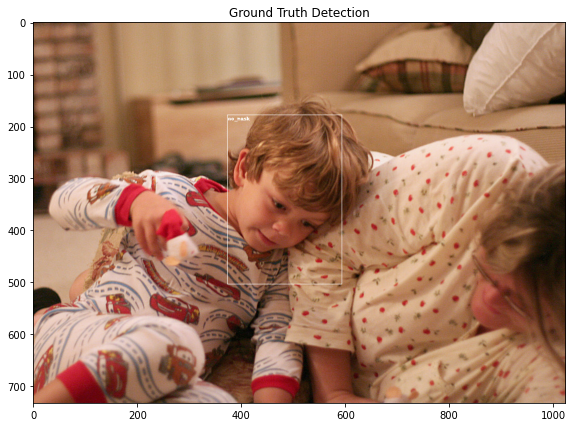

In [ ]:
# Parameters
img_id = 27

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get image sample
img = PIL.Image.open(os.path.join(val_img_dir,val_dataset.coco.loadImgs([img_id])[0]['file_name']))
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor,255).float().to(device)  # Format image for torchvision models
img_anns = val_dataset.coco.loadAnns(val_dataset.coco.getAnnIds([img_id]))

# Get label names
label_ids = val_dataset.coco.getCatIds()
label_info = val_dataset.coco.loadCats(label_ids)
label_names = [label['name'] for label in label_info]
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value

# Get ground truth bboxes
true_bboxes = convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
true_labels = [labels[obj['category_id']] for obj in img_anns]
true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels)
plt.figure(figsize = (25,7))
plt.title('Ground Truth Detection')
plot = plt.imshow(F.to_pil_image(true_img))

### Load pre-trained model

In [ ]:
%cd /content

# Delete utils package to reload it (if loaded), because YOLOv3 and YOLOv5 have
# the same name for it and it causes error
try:
  sys.modules.pop('utils')
except:
  pass

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'YOLOv5s' # @param ['SSD300 VGG16', 'SSDlite320 MobileNetV3-Large', 'Faster R-CNN ResNet-50 FPN', 'Faster R-CNN MobileNetV3-Large FPN', 'YOLOv5s', 'YOLOv5m', 'YOLOv5l', 'YOLOv3', 'YOLOv3-tiny', 'YOLOv3-spp']

# @markdown *Note: If you get the error "Cache may be out of date, try 'force_reload=True'" then restart runtime.*

if model_name == 'SSD300 VGG16':
  model_id = 'ssd300_vgg16'
  model = M.ssd300_vgg16(pretrained=True, progress=True)
  model_img_size = (3,300,300)
elif model_name == 'SSDlite320 MobileNetV3-Large':
  model_id = 'ssdlite320_mobilenet_v3_large'
  model = M.ssdlite320_mobilenet_v3_large(pretrained=True, progress=True)
  model_img_size = (3,320,320)
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn_resnet50_fpn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,1333,1333) 
elif model_name == 'Faster R-CNN MobileNetV3-Large FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, progress=True)
  model_img_size = (3,224,224) 
elif model_name == 'YOLOv5s':
  model_id = 'yolov5s'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5m':
  model_id = 'yolov5m'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5m')
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5l':
  model_id = 'yolov5l'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5l')
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3':
  model_id = 'yolov3'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3')
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-tiny':
  model_id = 'yolov3_tiny'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_tiny')
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-spp':
  model_id = 'yolov3_spp'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_spp')
  model_img_size = (3,640,640)

print('-------------------------------------------------------------------------------------------------------\n')

print(f'Loaded model: {model_name}')
model_params = sum([param.numel() for param in model.parameters()])
print(f'\t- Parameters: {round(model_params / 1000000, 1)}M')
model_macs, _ = get_model_complexity_info(model, model_img_size, as_strings=False, 
                                          print_per_layer_stat=False, verbose=False)
model_flops = 2 * int(model_macs)
print(f'\t- GFLOPS: {round(model_flops / 1000000000, 1)}')

/content


Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2021-8-26 torch 1.9.0+cu102 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]

Fusing layers... 


Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


-------------------------------------------------------------------------------------------------------

Loaded model: YOLOv5s
	- Parameters: 7.3M
	- GFLOPS: 17.0


### Train model on dataset

In [ ]:
# Mount GDrive to save model checkpoints
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set checkpoint path
ckpt_dir = '/content/drive/MyDrive/object-detection-checkpoints'
ckpt_file = f'mask_{model_id}'
ckpt_path = os.path.join(ckpt_dir,ckpt_file)

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f'Pre-trained Model: {model_name}')

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Construct learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Prepare model for new dataset
if 'Fast R-CNN' in model_name:
  num_classes = 3  # [BG, mask, no mask]
  # Get the number of input features for the classifier 
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # Replace the pre-trained head with a new one
  model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Train model
print_freq = 1
num_epochs = 10
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq, ckpt_path)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluator, fps, outputs = evaluate(model, val_data_loader, device)

Pre-trained Model: YOLOv5s


ValueError: ignored